In [1]:
import pandas as pd, numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import pickle

sns.set_palette("deep", desat=0.6)
sns.set_context(rc={"figure.figsize": (8,4)})
import json
from urllib.request import urlopen
import requests
from shapely.geometry import shape, Point

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt
import time
import folium

## Analyse pedestrian data w.r.to the SLOWZONE vision zero initiative and find *hot spots*

### Find out the *hot spots*  - where SLOWZONE = 1 , and then SLOWZONE=0 

### Load pedestrian incidents where the location is marked for Slow Zone.

In [173]:
#Read the data frame from pickle. Useful when you re-open this session and wanted to directly run this section.
dfpickle = pd.read_pickle('pedestrians.pkl')

In [174]:
dfslowzone = dfpickle[dfpickle['SLOWZONE'] == 1]

In [175]:
dfslowzone.head()

,Unnamed: 0,DATE,TIME,BOROUGH,ZIP.CODE,LATITUDE,LONGITUDE,LOCATION,ON.STREET.NAME,CROSS.STREET.NAME,...,VEHICLE.TYPE.CODE.2,VEHICLE.TYPE.CODE.3,VEHICLE.TYPE.CODE.4,VEHICLE.TYPE.CODE.5,DATENew,year,month,DAY_OF_WEEK,hour,SLOWZONE
0,16,02/27/2018,2018-03-24 10:13:00,BROOKLYN,11226.0,40.642690,-73.957640,"(40.64269, -73.95764)",CLARENDON ROAD,FLATBUSH AVENUE,...,NaN,NaN,NaN,NaN,2018-02-27,2018,2,1,10,1
16,248,02/27/2018,2018-03-24 16:40:00,MANHATTAN,10019.0,40.764520,-73.980780,"(40.76452, -73.98078)",NaN,NaN,...,NaN,NaN,NaN,NaN,2018-02-27,2018,2,1,16,1
17,251,02/27/2018,2018-03-24 16:45:00,QUEENS,11432.0,40.705826,-73.793970,"(40.705826, -73.79397)",JAMAICA AVENUE,MERRICK BOULEVARD,...,NaN,NaN,NaN,NaN,2018-02-27,2018,2,1,16,1
26,397,02/27/2018,2018-03-24 22:45:00,QUEENS,11368.0,40.757877,-73.859726,"(40.757877, -73.859726)",NaN,NaN,...,PASSENGER VEHICLE,NaN,NaN,NaN,2018-02-27,2018,2,1,22,1
41,755,02/26/2018,2018-03-24 16:02:00,NaN,NaN,40.675236,-73.971060,"(40.675236, -73.97106)",FLATBUSH AVENUE,PLAZA STREET WEST,...,NaN,NaN,NaN,NaN,2018-02-26,2018,2,0,16,1


In [176]:
dfslowzone.shape

(10500, 36)

In [177]:
dfslowzone.columns

Index(['Unnamed: 0', 'DATE', 'TIME', 'BOROUGH', 'ZIP.CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON.STREET.NAME', 'CROSS.STREET.NAME',
       'OFF.STREET.NAME', 'NUMBER.OF.PERSONS.INJURED',
       'NUMBER.OF.PERSONS.KILLED', 'NUMBER.OF.PEDESTRIANS.INJURED',
       'NUMBER.OF.PEDESTRIANS.KILLED', 'NUMBER.OF.CYCLIST.INJURED',
       'NUMBER.OF.CYCLIST.KILLED', 'NUMBER.OF.MOTORIST.INJURED',
       'NUMBER.OF.MOTORIST.KILLED', 'CONTRIBUTING.FACTOR.VEHICLE.1',
       'CONTRIBUTING.FACTOR.VEHICLE.2', 'CONTRIBUTING.FACTOR.VEHICLE.3',
       'CONTRIBUTING.FACTOR.VEHICLE.4', 'CONTRIBUTING.FACTOR.VEHICLE.5',
       'UNIQUE.KEY', 'VEHICLE.TYPE.CODE.1', 'VEHICLE.TYPE.CODE.2',
       'VEHICLE.TYPE.CODE.3', 'VEHICLE.TYPE.CODE.4', 'VEHICLE.TYPE.CODE.5',
       'DATENew', 'year', 'month', 'DAY_OF_WEEK', 'hour', 'SLOWZONE'],
      dtype='object')

### Identify clusters where SlowZone Marked as 1, but still causing accidents

In [178]:
kms_per_radian = 6371.0088

In [179]:
def getcoords(dframe):
    dfgeo1 = dframe.dropna(subset = ['LATITUDE','LONGITUDE'])
    coords = dfgeo1.as_matrix(columns=['LATITUDE','LONGITUDE'])
    return coords

In [180]:
coords = getcoords(dfslowzone)

In [181]:
coords

array([[ 40.64269  , -73.95764  ],
       [ 40.76452  , -73.98078  ],
       [ 40.705826 , -73.79397  ],
       ...,
       [ 40.6396243, -73.9547692],
       [ 40.8315678, -73.9429813],
       [ 40.7466595, -73.9900681]])

In [182]:
# define epsilon as 1 kilometers, converted to radians for use by haversine
epsilon = 1 / kms_per_radian
min_sample=50
epsilon

0.00015696101377226163

In [183]:
def applyDBSCAN(coordinates, epsilon, min_samples):
    start_time = time.time()
    db = DBSCAN(eps=epsilon, min_samples = min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates))
    cluster_labels = db.labels_
    # get the number of clusters
    num_clusters = len(set(cluster_labels))
    print(num_clusters)
    clusters = pd.Series([coordinates[cluster_labels==n] for n in range(num_clusters)])
    message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
    print(message.format(len(coordinates), num_clusters, 100*(1 - float(num_clusters) / len(coordinates)), time.time()-start_time))
    return clusters

In [184]:
clusters = applyDBSCAN(coords, epsilon, min_sample)

12
Clustered 10,500 points down to 12 clusters, for 99.9% compression in 0.50 seconds


In [185]:
def get_centermost_point(clusters):
    centroid = (MultiPoint(clusters).centroid.x, MultiPoint(clusters).centroid.y)
    centermost_point = min(clusters, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [186]:
#Find the point in each cluster that is closest to its centroid
def gethotspots(clusters, df):
    centermost_points = []
    for cluster in clusters.iteritems():
        if len(cluster[1]) >= min_sample:
            centermost_points.append(get_centermost_point(cluster[1]))
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    # that way we get the full details from the original dataframe
    rs = rep_points.apply(lambda row: df[(df['LATITUDE']==row['lat']) & 
                                             (df['LONGITUDE']==row['lon'])].iloc[0], axis=1)
    return rs

In [187]:
rs = gethotspots(clusters, dfslowzone)
#taking 6 digit of latitude and longitude after decimal point
rs.to_csv('testgeneral.csv', float_format='%.6f', encoding='utf-8')

In [188]:
rs.columns

Index(['Unnamed: 0', 'DATE', 'TIME', 'BOROUGH', 'ZIP.CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON.STREET.NAME', 'CROSS.STREET.NAME',
       'OFF.STREET.NAME', 'NUMBER.OF.PERSONS.INJURED',
       'NUMBER.OF.PERSONS.KILLED', 'NUMBER.OF.PEDESTRIANS.INJURED',
       'NUMBER.OF.PEDESTRIANS.KILLED', 'NUMBER.OF.CYCLIST.INJURED',
       'NUMBER.OF.CYCLIST.KILLED', 'NUMBER.OF.MOTORIST.INJURED',
       'NUMBER.OF.MOTORIST.KILLED', 'CONTRIBUTING.FACTOR.VEHICLE.1',
       'CONTRIBUTING.FACTOR.VEHICLE.2', 'CONTRIBUTING.FACTOR.VEHICLE.3',
       'CONTRIBUTING.FACTOR.VEHICLE.4', 'CONTRIBUTING.FACTOR.VEHICLE.5',
       'UNIQUE.KEY', 'VEHICLE.TYPE.CODE.1', 'VEHICLE.TYPE.CODE.2',
       'VEHICLE.TYPE.CODE.3', 'VEHICLE.TYPE.CODE.4', 'VEHICLE.TYPE.CODE.5',
       'DATENew', 'year', 'month', 'DAY_OF_WEEK', 'hour', 'SLOWZONE'],
      dtype='object')

### Hot Spots - Currently SlowZone Areas

In [189]:
rs[['LOCATION','BOROUGH','ON.STREET.NAME', 'CROSS.STREET.NAME']].sort_values('BOROUGH')

,LOCATION,BOROUGH,ON.STREET.NAME,CROSS.STREET.NAME
3,"(40.8478547, -73.895578)",BRONX,THIRD AVENUE,EAST 178 STREET
0,"(40.669098, -73.93666)",BROOKLYN,EASTERN PARKWAY,TROY AVENUE
6,"(40.61463, -73.96325)",BROOKLYN,NaN,NaN
1,"(40.7655201, -73.9800367)",MANHATTAN,WEST 57 STREET,7 AVENUE
2,"(40.7507179, -73.8587648)",QUEENS,ROOSEVELT AVENUE,108 STREET
5,"(40.7128656, -73.9047713)",QUEENS,METRO AVENUE,ELIOT AVENUE
7,"(40.71731, -73.739842)",QUEENS,JAMAICA AVENUE,215 PLACE
4,"(40.6366233, -74.0817779)",STATEN ISLAND,VICTORY BOULEVARD,WESTERVELT AVENUE
9,"(40.6242451, -74.1382622)",STATEN ISLAND,MARIANNE STREET,FOREST AVENUE
8,"(40.727966, -73.95007)",NaN,MEEKER AVENUE,MC GUINNESS BLVD SOUTH


In [190]:
def plotHotSpots(orgdf, rset):
    # plot the final reduced set of coordinate points vs the original full set
    fig, ax = plt.subplots(figsize=[17.5, 17])
    df_scatter1 = ax.scatter(orgdf['LONGITUDE'], orgdf['LATITUDE'], c='k', alpha=0.9, s=3)
    rs_scatter1 = ax.scatter(rset['LONGITUDE'], rset['LATITUDE'], c='#FF8C00', edgecolor='None', alpha=0.7, s=120)
    ax.set_title('Full data set vs DBSCAN reduced set')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-74.06, -73.77)
    ax.set_ylim(40.61, 40.91)
    ax.legend([df_scatter1, rs_scatter1], ['Full set', 'Reduced set'], loc='upper right')
    plt.show()

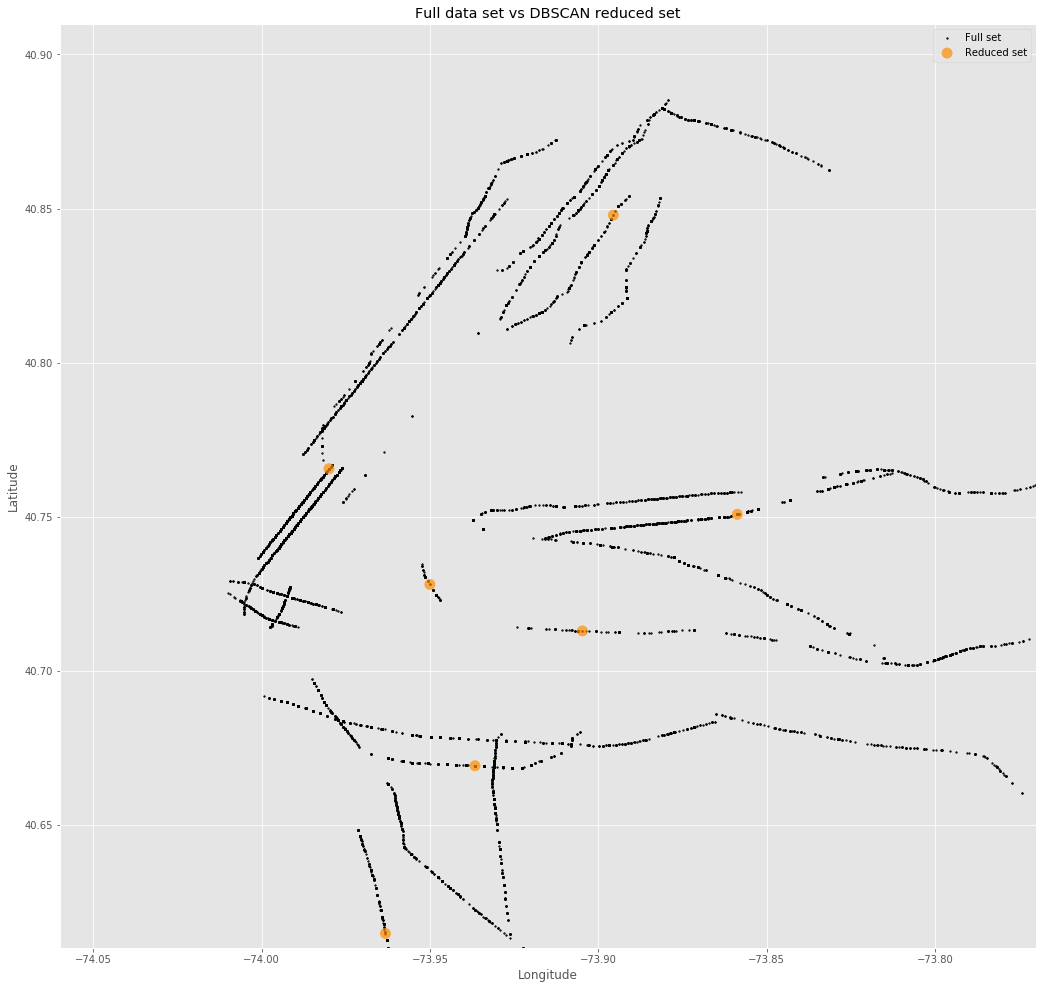

In [191]:
plotHotSpots(dfslowzone, rs)

In [192]:
rs.columns

Index(['Unnamed: 0', 'DATE', 'TIME', 'BOROUGH', 'ZIP.CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON.STREET.NAME', 'CROSS.STREET.NAME',
       'OFF.STREET.NAME', 'NUMBER.OF.PERSONS.INJURED',
       'NUMBER.OF.PERSONS.KILLED', 'NUMBER.OF.PEDESTRIANS.INJURED',
       'NUMBER.OF.PEDESTRIANS.KILLED', 'NUMBER.OF.CYCLIST.INJURED',
       'NUMBER.OF.CYCLIST.KILLED', 'NUMBER.OF.MOTORIST.INJURED',
       'NUMBER.OF.MOTORIST.KILLED', 'CONTRIBUTING.FACTOR.VEHICLE.1',
       'CONTRIBUTING.FACTOR.VEHICLE.2', 'CONTRIBUTING.FACTOR.VEHICLE.3',
       'CONTRIBUTING.FACTOR.VEHICLE.4', 'CONTRIBUTING.FACTOR.VEHICLE.5',
       'UNIQUE.KEY', 'VEHICLE.TYPE.CODE.1', 'VEHICLE.TYPE.CODE.2',
       'VEHICLE.TYPE.CODE.3', 'VEHICLE.TYPE.CODE.4', 'VEHICLE.TYPE.CODE.5',
       'DATENew', 'year', 'month', 'DAY_OF_WEEK', 'hour', 'SLOWZONE'],
      dtype='object')

In [193]:
def plotHotSpots_Folium(rs):
    NY_COORDINATES = (40.61, -74.06)
    # create empty map zoomed in on NYC
    map = folium.Map(location=NY_COORDINATES, zoom_start=11)
    
    for each in rs.iterrows():
        folium.CircleMarker(
            location = [each[1]['LATITUDE'],each[1]['LONGITUDE']],
            radius = 12, popup= str(each[1]['BOROUGH']) + ": " + str(each[1]["ON.STREET.NAME"]) + "(zip:" + str(each[1]["ZIP.CODE"]) + ")",
        fill=True, color='#3186cc', fill_color='#FF8C00', fill_opacity=0.7).add_to(map)
    
    display(map)

In [194]:
plotHotSpots_Folium(rs)

### Lets looks for HotSpots in *non slowzone* areas 

In [156]:
dfpickle = pd.read_pickle('pedestrians.pkl')
dfnonslowzone = dfpickle[dfpickle['SLOWZONE'] == 0]
dfnonslowzone = dfnonslowzone.dropna(subset = ['LATITUDE','LONGITUDE', 'ON.STREET.NAME'])

In [157]:
dfpickle.shape


(85037, 36)

In [158]:
dfnonslowzone.shape

(58745, 36)

In [159]:
coords_nonslowzone = getcoords(dfnonslowzone)

In [160]:
coords_nonslowzone

array([[ 40.8475   , -73.86696  ],
       [ 40.645027 , -73.91998  ],
       [ 40.83511  , -73.91945  ],
       ...,
       [ 40.8626793, -73.9090397],
       [ 40.6945453, -73.802112 ],
       [ 40.7578587, -73.975592 ]])

In [161]:
len(coords_nonslowzone)

58745

In [168]:
epsilon = 1 / kms_per_radian
min_sample=50
print(epsilon)
print(min_sample)
clusters_nonslowzone = applyDBSCAN(coords_nonslowzone, epsilon, min_sample)
print(clusters_nonslowzone)

0.00015696101377226163
50
8
Clustered 58,745 points down to 8 clusters, for 100.0% compression in 7.95 seconds
0    [[40.8475, -73.86695999999999], [40.645027, -7...
1    [[40.587193, -73.81598000000001], [40.58905, -...
2    [[40.60172, -74.09143], [40.59075, -74.08837],...
3    [[40.602191999999995, -73.75523000000001], [40...
4    [[40.737137, -73.70923], [40.73444, -73.72179]...
5    [[40.545395, -74.16575], [40.550765999999996, ...
6    [[40.900288, -73.89704], [40.906859999999995, ...
7                                                   []
dtype: object


In [169]:
rsnsz = gethotspots(clusters_nonslowzone, dfnonslowzone)

### Hot Spots - Currently where there is no SlowZone initiative 

In [170]:
rsnsz[['LOCATION','BOROUGH','ON.STREET.NAME', 'CROSS.STREET.NAME']].sort_values('BOROUGH')

,LOCATION,BOROUGH,ON.STREET.NAME,CROSS.STREET.NAME
6,"(40.9065695, -73.9021603)",BRONX,WEST 259 STREET,LIEBIG AVENUE
0,"(40.7278075, -73.9265889)",QUEENS,57 AVENUE,43 STREET
1,"(40.5875659, -73.8112535)",QUEENS,ROCKAWAY BEACH BOULEVARD,BEACH 86 STREET
3,"(40.602192, -73.75523)",QUEENS,CORNAGA AVENUE,BEACH 22 STREET
4,"(40.7406084, -73.7124586)",QUEENS,257 STREET,82 AVENUE
2,"(40.610261, -74.0974882)",STATEN ISLAND,MILFORD DRIVE,CLOVE ROAD
5,"(40.5488139, -74.1543344)",STATEN ISLAND,AMBOY ROAD,SHERWOOD PLACE


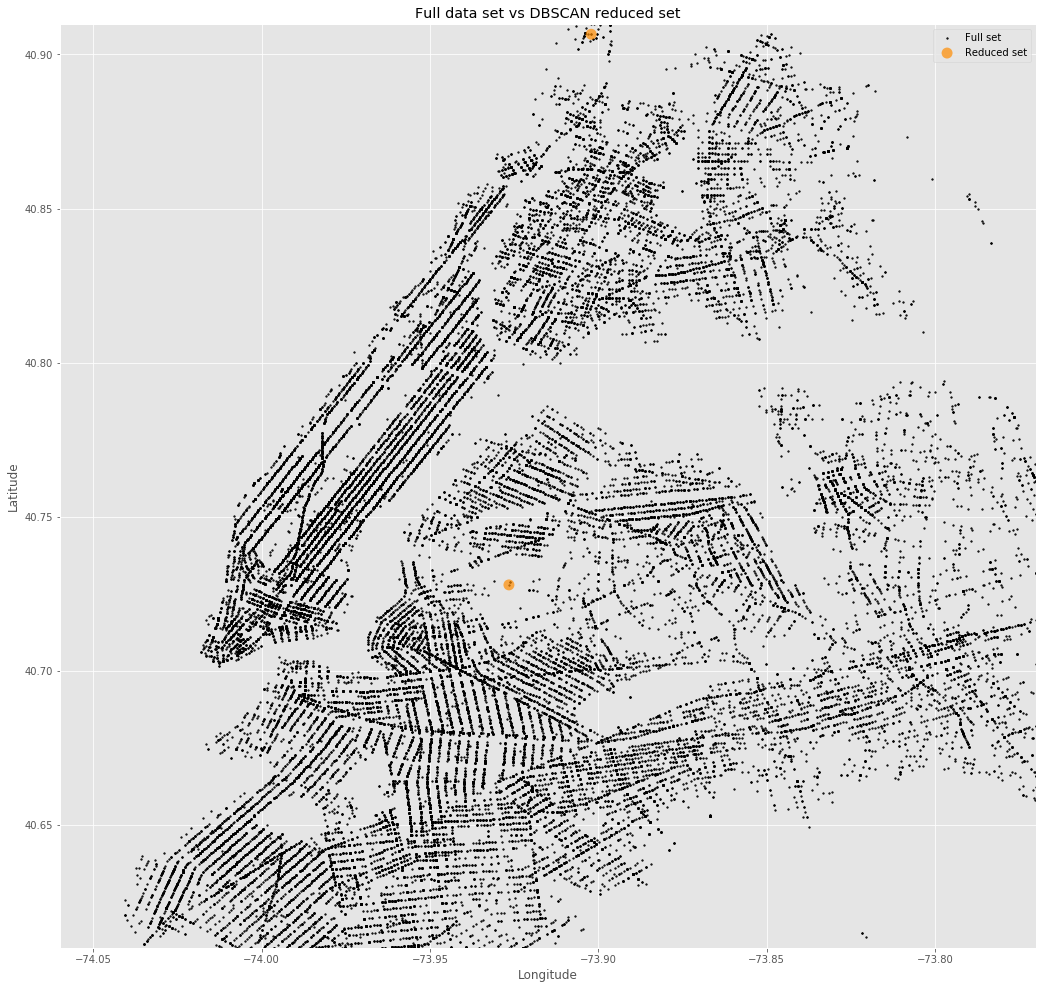

In [171]:
plotHotSpots(dfnonslowzone, rsnsz)

Review the hot spots above and install speed zones

In [172]:
plotHotSpots_Folium(rsnsz)